# BERTje preprocessing pipeline

The NLP team developed a sentence-annotor model. To pre-process their data, they used CONLL formatting and then BERTje embedding to produce their input matrix. For synthesising annotations on unseen data, this pre-processing needs to be replicated exactly, but without going via the INCEPTION annotion platform and without as many intermediate steps. 

**This script was to replicate the pre-processing steps needed to produce the input matrix for the sentence-annotator model.**

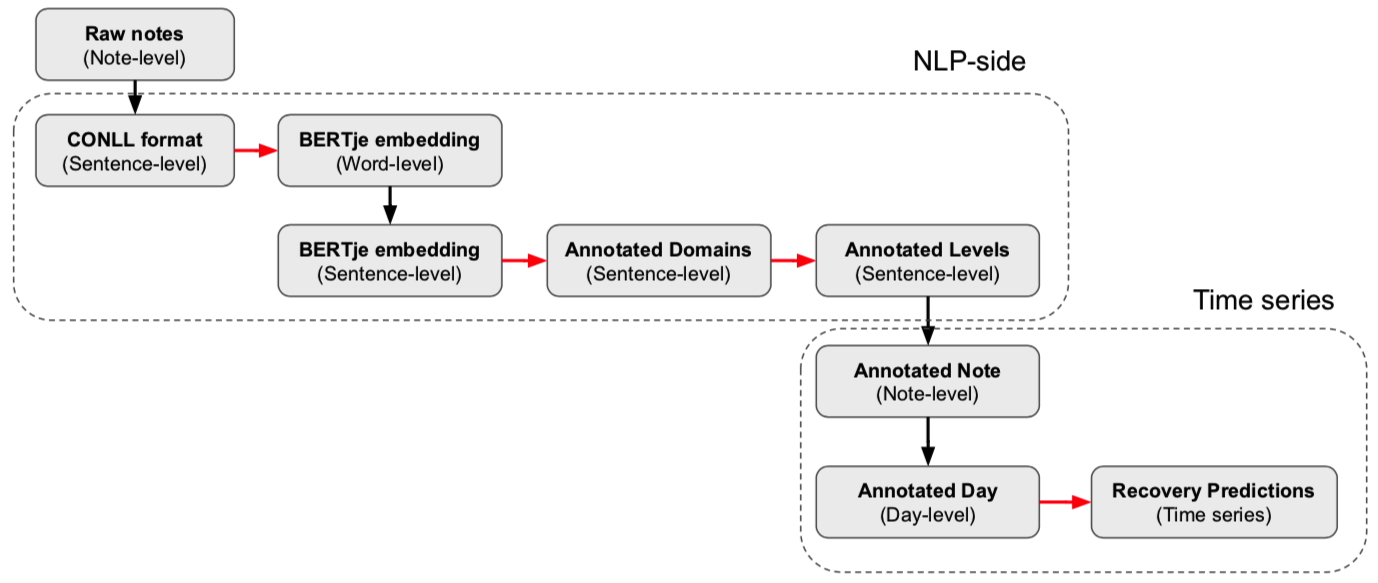

In [1]:
import os
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
import spacy
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

from class_definitions import Annotation, BertContainer
from TextToConll import text_to_conll
from transformers import BertModel, BertTokenizer  # change

# Make graphics nice
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Set sensible defaults
sns.set()
sns.set_style("ticks")
sns.set_context('paper')

In [2]:
#!python -m spacy download nl_core_news_sm

In [3]:
# sample text
text = "Ik ben makelaar in koffi, en woon op de Lauriergracht No 37. Het is mijn gewoonte niet, romans te schrijven, of zulke dingen, en het heeft dan ook lang geduurd, voor ik er toe overging een paar riem papier extra te bestellen, en het werk aan te vangen, dat gij, lieve lezer, zoâven in de hand hebt genomen, en dat ge lezen moet als ge makelaar in koffie zijt, of als ge wat anders zijt. Niet alleen dat ik nooit iets schreef wat naar een roman geleek, maar ik houd er zelfs niet van, iets dergelijks te lezen, omdat ik een man van zaken ben."

In [4]:
# Convert a body of text to a list of sentences (as strings) using SpaCy's Dutch corpus
print(text)
doc = spacy.load('nl_core_news_sm')(text)
sentences = [str(sent) for sent in doc.sents]
print(sentences)

Ik ben makelaar in koffi, en woon op de Lauriergracht No 37. Het is mijn gewoonte niet, romans te schrijven, of zulke dingen, en het heeft dan ook lang geduurd, voor ik er toe overging een paar riem papier extra te bestellen, en het werk aan te vangen, dat gij, lieve lezer, zoâven in de hand hebt genomen, en dat ge lezen moet als ge makelaar in koffie zijt, of als ge wat anders zijt. Niet alleen dat ik nooit iets schreef wat naar een roman geleek, maar ik houd er zelfs niet van, iets dergelijks te lezen, omdat ik een man van zaken ben.
['Ik ben makelaar in koffi, en woon op de Lauriergracht', 'No 37.', 'Het is mijn gewoonte niet, romans te schrijven, of zulke dingen, en het heeft dan ook lang geduurd, voor ik er toe overging een paar riem papier extra te bestellen, en het werk aan te vangen, dat gij, lieve lezer, zoâven in de hand hebt genomen, en dat ge lezen moet als ge makelaar in koffie zijt, of als ge wat anders zijt.', 'Niet alleen dat ik nooit iets schreef wat naar een roman gel

In [5]:
def get_BERTje_encoding(sentence, model, tokenizer):
    #get progressed inputs
    marked_text = '[CLS] ' + sentence + ' [SEP]'
    tokenized_text = tokenizer.tokenize(marked_text)
    token_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
    segment_ids = [1] * len(tokenized_text)

    # convert inputs to PyTorch tensors
    segments_tensors = torch.tensor([segment_ids])
    tokens_tensor = torch.tensor([token_ids])

    # run sentence through BERTje and collect all hidden states from all 12 (13?) layers
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2]

    # Averaging across dummy dimension and leveraging CLS-token repr. (as was done for model-development)
    token_vecs = list(hidden_states)
#     print(len(token_vecs), token_vecs[0].shape)
    token_vecs = torch.cat(token_vecs[-4:])
#     print(token_vecs.shape)
    sentence_embedding = torch.mean(token_vecs, dim=0).numpy()[0]
#     print(sentence_embedding.shape)

    return sentence_embedding

BERTJE_MODEL = "wietsedv/bert-base-dutch-cased"
model = BertModel.from_pretrained(BERTJE_MODEL, output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained(BERTJE_MODEL)

encodings = []
for sentence in sentences:
    encodings.append(get_BERTje_encoding(sentence, model, tokenizer))

In [6]:
encodings[0].shape

(768,)

In [7]:
MODELS_DIR = Path("//data2/Documents/a-proof/machine_learning_clean/bestmodels")

with open(MODELS_DIR/'best_model_stemming.sav', 'rb') as file:
    model_dom_stm = pickle.load(file)
    
with open(MODELS_DIR/'best_model_STM.sav', 'rb') as file:
    model_lev_stm = pickle.load(file)
    
with open(MODELS_DIR/'best_model_lopen.sav', 'rb') as file:
    model_dom_fac = pickle.load(file)
    
with open(MODELS_DIR/'best_model_FAC.sav', 'rb') as file:
    model_lev_fac = pickle.load(file)

In [7]:
# Set up lists for calculated values
stm_agg, stm_std, stm_count, fac_agg, fac_std, fac_count = [], [], [], [], [], []

# Loop through all the notes and generate STM and FAC annotations using best Domain/Level models

for note in tqdm(df['note']):
    
    # Parse note into a list of sentences (as strings)
    sentences = [str(sent) for sent in spacy_tokenizer(note).sents]
    
    # Generate a BERTje encoding vector for each sentence
    encodings = []
    for sentence in sentences:
        encodings.append(get_BERTje_encoding(sentence, model, tokenizer))
    
    # Determine the domain consenus, then the level
    stm_preds = model_dom_stm.predict(encodings)
    fac_preds = model_dom_fac.predict(encodings)
    
    stm_levels = np.where((stm_preds == '.B152: Stemming') | (fac_preds == '.B152: Stemming'), model_lev_stm.predict(encodings), np.nan)
    fac_levels = np.where((stm_preds == '.D450: Lopen en zich verplaatsen') | (fac_preds == '.D450: Lopen en zich verplaatsen'), model_lev_fac.predict(encodings), np.nan)
    
    stm_count.append(np.sum([(stm_preds == '.B152: Stemming') | (fac_preds == '.B152: Stemming')]))
    fac_count.append(np.sum([(stm_preds == '.D450: Lopen en zich verplaatsen') | (fac_preds == '.D450: Lopen en zich verplaatsen')]))

    # Aggregate the sentence-level predictions for STM and FAC, ignoring NaNs (and warnings about them)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        stm_agg.append(np.nanmedian(stm_levels))
        stm_std.append(np.nanstd(stm_levels))
    
        fac_agg.append(np.nanmedian(fac_levels))
        fac_std.append(np.nanstd(fac_levels))

100%|██████████| 2485/2485 [2:15:37<00:00,  3.27s/it]  


In [8]:
MODELS_DIR = "//data2/Documents/a-proof/machine_learning_clean/bestmodels"

for path in Path(MODELS_DIR).glob("*"):
    with open(path, 'rb') as file:
        model = pickle.load(file)

    print(path.name, type(model))
    print(model.predict(encodings))

best_model_stemming.sav <class 'sklearn.svm._classes.SVC'>
['None' 'None' 'None' 'None']
best_model_lopen.sav <class 'sklearn.svm._classes.SVC'>
['None' 'None' 'None' 'None']
best_model_FAC.sav <class 'sklearn.svm._classes.SVR'>
[3.11726907 1.53174638 1.60658423 1.77439269]
best_model_STM.sav <class 'sklearn.svm._classes.SVR'>
[1.47001901 2.04517597 1.48557446 0.88882032]


In [9]:
# Sanity check a known encoding

# sent = "Iom arts nu even accepteren tot 7.25 en later opnieuw ABG ."
# get_BERTje_encoding(sent, model, tokenizer)[0]